In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

import dqn_agent
#from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()

In [2]:
env_name = 'CartPole-v0'  # @param
num_iterations = 20000  # @param

initial_collect_steps = 1000  # @param
collect_steps_per_iteration = 1  # @param
replay_buffer_capacity = 100000  # @param

fc_layer_params = (100,)

batch_size = 64  # @param
learning_rate = 1e-3  # @param
log_interval = 200  # @param

num_eval_episodes = 10  # @param
eval_interval = 1000  # @param

In [3]:
env = suite_gym.load(env_name)

In [4]:
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Action Spec:')
print(env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name=None, minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name=None, minimum=0, maximum=1)


In [5]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [6]:
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

In [7]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.compat.v2.Variable(0)

tf_agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=dqn_agent.element_wise_squared_loss,
    train_step_counter=train_step_counter)
tf_agent.initialize()

collect policy is e-greedy


In [8]:
eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

In [9]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [10]:
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

In [11]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

In [12]:
def collect_step(environment, policy):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    replay_buffer.add_batch(traj)

for _ in range(initial_collect_steps):
    collect_step(train_env, random_policy)

In [13]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size, num_steps=2).prefetch(3)

iterator = iter(dataset)

In [14]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
tf_agent.train = common.function(tf_agent.train)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

    # Collect a few steps using collect_policy and save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_step(train_env, tf_agent.collect_policy)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = tf_agent.train(experience)

    step = tf_agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss.loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)


W0708 09:04:39.997025 4561159616 deprecation.py:323] From /Users/jwatts/TensorflowProjects/lib/python3.7/site-packages/tf_agents/policies/epsilon_greedy_policy.py:96: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


td_errors_loss_fn=<function element_wise_squared_loss at 0x141512ea0>
_n_step_update=1
no state spec, map structure
multi_dim_actions=False
reward_scale_factor=1.0; gamma=1.0
td_errors_loss_fn=<function element_wise_squared_loss at 0x141512ea0>
_n_step_update=1
no state spec, map structure
multi_dim_actions=False
reward_scale_factor=1.0; gamma=1.0
step = 200: loss = 12.647035598754883
step = 400: loss = 31.06681251525879
step = 600: loss = 17.79585838317871
step = 800: loss = 29.510196685791016
step = 1000: loss = 71.55635833740234
step = 1000: Average Return = 44.70000076293945
step = 1200: loss = 34.57028579711914
step = 1400: loss = 29.073408126831055
step = 1600: loss = 57.44021224975586
step = 1800: loss = 19.16401481628418
step = 2000: loss = 67.837646484375
step = 2000: Average Return = 26.600000381469727
step = 2200: loss = 21.267086029052734
step = 2400: loss = 60.337196350097656
step = 2600: loss = 55.717159271240234
step = 2800: loss = 18.117290496826172
step = 3000: loss = 

(17.930000400543214, 250)

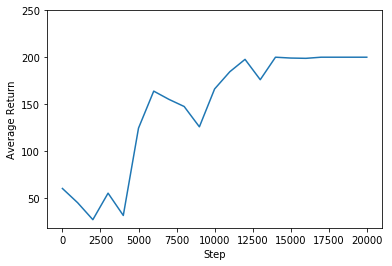

In [15]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=250)

In [16]:
time_step = eval_env.reset()
while not time_step.is_last():
    action_step = tf_agent.policy.action(time_step)
    time_step = eval_env.step(action_step.action)
    eval_py_env.render()

In [23]:
def _experience_to_transitions(experience):
    transitions = trajectory.to_transition(experience)

    transitions = tf.nest.map_structure(lambda x: tf.squeeze(x, [1]), transitions)

    time_steps, policy_steps, next_time_steps = transitions
    actions = policy_steps.action
    return time_steps, actions, next_time_steps

def element_wise_squared_loss(x, y):
    return tf.compat.v1.losses.mean_squared_error(x, y, reduction=tf.compat.v1.losses.Reduction.NONE)

def element_wise_huber_loss(x, y):
    return tf.compat.v1.losses.huber_loss(x, y, reduction=tf.compat.v1.losses.Reduction.NONE)

def compute_td_targets(next_q_values, rewards, discounts):
    return tf.stop_gradient(rewards + discounts * next_q_values)

def dqn_compute_next_q_values(self, next_time_steps):
    next_target_q_values, _ = self._target_q_network(next_time_steps.observation, next_time_steps.step_type)
    return tf.reduce_max(input_tensor=next_target_q_values, axis=-1)

def ddqn_compute_next_q_values(self, next_time_steps):
    next_q_values, _ = self._q_network(next_time_steps.observation,
                                       next_time_steps.step_type)
    best_next_actions = tf.cast(
        tf.argmax(input=next_q_values, axis=-1), dtype=tf.int32)
    
    next_target_q_values, _ = self._target_q_network(
        next_time_steps.observation, next_time_steps.step_type)
    
    multi_dim_actions = best_next_actions.shape.ndims > 1
    
    return common.index_with_actions(
        next_target_q_values,
        best_next_actions,
        multi_dim_actions=multi_dim_actions)

def _loss(self,
          experience,
          td_errors_loss_fn=element_wise_squared_loss,
          gamma=1.0,
          reward_scale_factor=1.0):
    
    time_steps, actions, next_time_steps = self._experience_to_transitions(experience)

    with tf.name_scope('loss'):
        q_values, _ = self._q_network(time_steps.observation,
                                      time_steps.step_type)

        q_values = common.index_with_actions(q_values,
                                             tf.cast(actions, dtype=tf.int32),
                                             multi_dim_actions=False)

        next_q_values = dqn_compute_next_q_values(self, next_time_steps)

        td_targets = compute_td_targets(next_q_values,
                                        rewards=reward_scale_factor * next_time_steps.reward,
                                        discounts=gamma * next_time_steps.discount)

        valid_mask = tf.cast(~time_steps.is_last(), tf.float32)
        td_error = valid_mask * (td_targets - q_values)

        td_loss = valid_mask * td_errors_loss_fn(td_targets, q_values)

        loss = tf.reduce_mean(input_tensor=td_loss)
        
        return loss, td_loss, td_error
    
def _train(self, experience):
    with tf.GradientTape() as tape:
        loss, td_loss, td_error = _loss(self, experience)
        
    variables_to_train = self._q_network.trainable_weights

    grads = tape.gradient(loss, variables_to_train)
    # Tuple is used for py3, where zip is a generator producing values once.
    grads_and_vars = tuple(zip(grads, variables_to_train))
    
    self._optimizer.apply_gradients(grads_and_vars,
                                    global_step=self.train_step_counter)

    self._update_target()

    return loss, td_loss, td_error

In [31]:
experience, unused_info = next(iterator)

loss, td_loss, td_error = _train(tf_agent, experience)

no state spec, map structure


In [32]:
print(loss)
print(td_loss)
print(td_error)

tf.Tensor(35.04481, shape=(), dtype=float32)
tf.Tensor(
[3.78888935e-01 1.33157730e+01 2.27957654e+00 1.62405348e+00
 2.17294312e+00 1.19236507e-01 4.52400742e+01 1.64778814e-01
 1.23210136e+02 1.70909882e+01 2.32551336e+00 1.07562757e+00
 3.55849862e+00 6.36713207e-01 2.63366795e+01 4.16435577e+02
 2.92448831e+00 4.71523970e-01 4.45435667e+00 4.02125816e+01
 6.46726532e+01 7.21317649e-01 3.49790907e+00 2.71748657e+01
 2.85208679e+02 1.63425887e+00 5.28759289e+00 1.09741735e+00
 2.94753761e+01 2.32595444e+01 2.98623681e+00 1.94531322e+00
 3.25009232e+01 3.49029907e+02 4.14260626e+00 1.89885883e+01
 2.92070836e-01 3.74208999e+00 4.57901993e+01 4.08018708e-01
 1.22401869e+00 6.40908539e-01 3.20336580e+00 1.54813245e-01
 7.37054825e+01 5.41661406e+00 4.30896915e-02 1.51563084e+00
 1.49667978e+00 3.71509018e+01 1.22739375e-01 6.88067436e-01
 3.94295692e-01 5.94698524e+01 9.09104943e-02 2.00414968e+00
 3.34235573e+01 1.12032270e+01 4.58005476e+00 2.32201163e-03
 3.40268951e+02 2.18348242e-0